In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [3]:
def logistic(x, epsilon=1e-5):
    return 1 / (1 + np.exp(-x) + epsilon)

def log(x, epsilon=1e-5):
    """Log function that avoids divide by zero errors"""
    return np.log(x + epsilon)

def log_prior(w, variance):
    return -1 / (2 * variance) * (w.T @ w)

def log_likelihood(w, X, y):
    sigma = logistic(X @ w)
    return np.sum(y * log(sigma)
                  + (1 - y) * log(1 - sigma))

def log_likelihood_gradient(w, X, y):
    return (y - logistic(X @ w)) @ X

def log_posterior(w, X, y, prior_variance):
    return log_likelihood(w, X, y) + log_prior(w, prior_variance)

def posterior_gradient(w, X, y, prior_variance):
    return (y - logistic(X @ w)) @ X - w / prior_variance

from scipy.optimize import fmin_l_bfgs_b as minimise


def find_w_map(X, y, prior_variance=1, w0=None):
    if w0 is None:
        w0 = np.random.normal(size=X.shape[1])
        
    w_map, *d = minimise(lambda w, X, y, prior_variance: -log_posterior(w, X, y, prior_variance),
                         w0,
                         lambda w, X, y, prior_variance: -posterior_gradient(w, X, y, prior_variance),
                         args=[X, y, prior_variance])
    return w_map

def find_w_ml(X, y, w0=None):
    if w0 is None:
        w0 = np.random.normal(size=X.shape[1])
        
    w_ml, *d = minimise(lambda w, X, y: -log_likelihood(w, X, y),
                        w0,
                        lambda w, X, y: -log_likelihood_gradient(w, X, y),
                        args=[X, y])
    return w_ml

In [4]:
# customer churn dataset
df = pd.read_csv(r'C:\Users\vidha\Desktop\IISc\CP218 - Theory and applications of bayesian learning\Project2\Datasets\Iranian-Churn-Dataset-Data-Set\Customer Churn.csv')
print(df)

      Call Failure  Complains  Subscription Length  Charge Amount  \
0                8          0                   38              0   
1                0          0                   39              0   
2               10          0                   37              0   
3               10          0                   38              0   
4                3          0                   38              0   
...            ...        ...                  ...            ...   
3145            21          0                   19              2   
3146            17          0                   17              1   
3147            13          0                   18              4   
3148             7          0                   11              2   
3149             8          1                   11              2   

      Seconds of Use  Frequency of use  Frequency of SMS  \
0               4370                71                 5   
1                318                 5             

In [5]:
# customer churn datset
df.corr()['Churn']

Call Failure              -0.008987
Complains                  0.532053
Subscription Length       -0.032588
Charge Amount             -0.202305
Seconds of Use            -0.298935
Frequency of use          -0.303337
Frequency of SMS          -0.220754
Distinct Called Numbers   -0.278867
Age Group                 -0.014550
Tariff Plan               -0.105853
Status                     0.498976
Age                       -0.017705
Customer Value            -0.289144
Churn                      1.000000
Name: Churn, dtype: float64

In [6]:
# customer churn dataset
df_selected = df[['Call Failure','Complains', 'Subscription Length', 'Charge Amount', 'Seconds of Use', 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers','Status', 'Customer Value','Churn']]

In [7]:
df_selected.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Status,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,1,197.640,0
1,0,0,39,0,318,5,7,4,2,46.035,0
2,10,0,37,0,2453,60,359,24,1,1536.520,0
3,10,0,38,0,4198,66,1,35,1,240.020,0
4,3,0,38,0,2393,58,2,33,1,145.805,0


In [8]:
print("correlation of features with output :")
print(df_selected.corr()['Churn'])
columns = list(df_selected.columns)
corr_list = list(abs(df_selected.corr()['Churn']))[0:-1]
array_selected = df_selected.values
input_idx = [i for i in range(len(columns) - 1)]
output_idx = [input_idx[-1] + 1]

correlation of features with output :
Call Failure              -0.008987
Complains                  0.532053
Subscription Length       -0.032588
Charge Amount             -0.202305
Seconds of Use            -0.298935
Frequency of use          -0.303337
Frequency of SMS          -0.220754
Distinct Called Numbers   -0.278867
Status                     0.498976
Customer Value            -0.289144
Churn                      1.000000
Name: Churn, dtype: float64


In [9]:
X = array_selected[:,input_idx]
y = array_selected[:,output_idx].astype('int')

In [10]:
def choose_features(num_of_features_choosen):
    temp1 = list(np.argsort(corr_list)[::-1][:num_best_features])
    temp2 = [input_idx[val] for val in temp1]
    choosen_features = [columns[val] for val in temp2]
    return choosen_features

In [11]:
MAX_DEGREE = 7
num_best_features_list = [i for i in range(1,len(columns))]
n_list = [i for i in range(1,MAX_DEGREE + 1)] # degree list
for num_best_features in num_best_features_list:
    choosen_features = choose_features(num_best_features)
    print("\nchoosen features :\n",choosen_features)
    input_features = np.array(df_selected[choosen_features]).reshape(-1,len(choosen_features))
    output_features = np.array(df_selected[['Churn']]).reshape(-1,1)

    X_train, X_test, y_train, y_test = train_test_split(input_features, output_features, test_size = 0.25)

    scaler = MinMaxScaler()
    prior_variance = 1
    # transform data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.fit_transform(y_test)
    for n in n_list:
        # bayesain logistic regression
        poly = PolynomialFeatures(degree = n, interaction_only=False, include_bias=False)
        X_train_scaled_poly = poly.fit_transform(X_train_scaled)
        X_test_scaled_poly = poly.fit_transform(X_test_scaled)

        coeff = find_w_map(X_train_scaled_poly, y_train_scaled.flatten(), prior_variance=prior_variance)
        coeff = np.array(coeff).reshape(-1,1)
        y_pred = logistic(np.dot(X_test_scaled_poly,coeff))
        predictions = []
        for elem in y_pred:
            if(elem<0.5):
                predictions.append(0)
            else:
                predictions.append(1)
        correct = 0
        for i in range(len(predictions)):
            if(predictions[i]==list(y_test_scaled.flatten())[i]):
                correct = correct + 1

        score = correct/len(predictions)
        
        print(f"accuracy with degree = {n} is {score}")
#         confusion_matrix(y_test_scaled, np.array(predictions).reshape(len(predictions),1))


choosen features :
 ['Complains']
accuracy with degree = 1 is 0.9010152284263959
accuracy with degree = 2 is 0.9010152284263959
accuracy with degree = 3 is 0.9010152284263959
accuracy with degree = 4 is 0.9010152284263959
accuracy with degree = 5 is 0.9010152284263959
accuracy with degree = 6 is 0.9010152284263959
accuracy with degree = 7 is 0.9010152284263959

choosen features :
 ['Complains', 'Status']
accuracy with degree = 1 is 0.8857868020304569
accuracy with degree = 2 is 0.8857868020304569
accuracy with degree = 3 is 0.8857868020304569
accuracy with degree = 4 is 0.8857868020304569
accuracy with degree = 5 is 0.8857868020304569
accuracy with degree = 6 is 0.8857868020304569
accuracy with degree = 7 is 0.8857868020304569

choosen features :
 ['Complains', 'Status', 'Frequency of use']
accuracy with degree = 1 is 0.8972081218274112
accuracy with degree = 2 is 0.8972081218274112
accuracy with degree = 3 is 0.9048223350253807
accuracy with degree = 4 is 0.9035532994923858
accuracy 

In [12]:
y_test_scaled.shape

(788, 1)

using pca

In [16]:
n = 1
num_best_features = 10
choosen_features = choose_features(num_best_features)
print("\nchoosen features :\n",choosen_features)
input_features = np.array(df_selected[choosen_features]).reshape(-1,len(choosen_features))
output_features = np.array(df_selected[['Churn']]).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(input_features, output_features, test_size = 0.25)
scaler = MinMaxScaler()
# transform data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.fit_transform(y_test)


choosen features :
 ['Complains', 'Status', 'Frequency of use', 'Seconds of Use', 'Customer Value', 'Distinct Called Numbers', 'Frequency of SMS', 'Charge Amount', 'Subscription Length', 'Call Failure']


[0.45, 0.17, 0.13, 0.1, 0.06, 0.05, 0.02, 0.02, 0.0, 0.0]


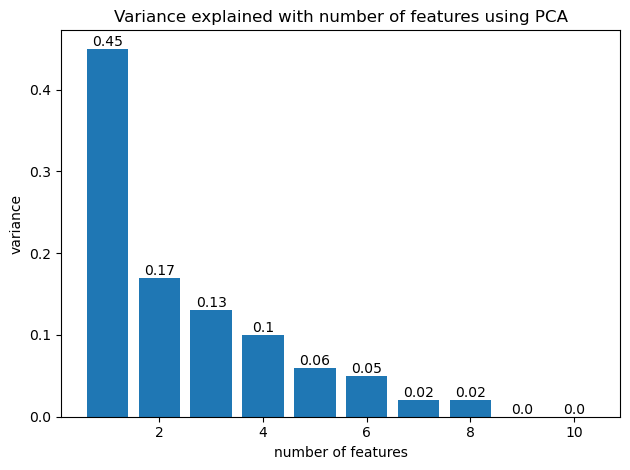

In [17]:
pca = PCA()
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance=[round(elem,2) for elem in explained_variance]
print(explained_variance)
x_bar = [i for i in range(1,len(explained_variance)+1)]
fig = plt.bar(x =x_bar, height=explained_variance)
plt.bar_label(labels=explained_variance,container=fig)

plt.title('Variance explained with number of features using PCA')
plt.xlabel("number of features")
plt.ylabel("variance")
plt.tight_layout()
plt.savefig("plots/variance_explained_pca_bayesian_logistic.jpg",dpi=150)

accuracy with degree = 1 is 0.8401015228426396
sensitivity with degree = 1 is 0.8852459016393442
accuracy with degree = 2 is 0.9022842639593909
sensitivity with degree = 2 is 0.5245901639344263
accuracy with degree = 3 is 0.9073604060913706
sensitivity with degree = 3 is 0.5
accuracy with degree = 4 is 0.9073604060913706
sensitivity with degree = 4 is 0.4918032786885246
accuracy with degree = 5 is 0.9060913705583756
sensitivity with degree = 5 is 0.47540983606557374
accuracy with degree = 6 is 0.9073604060913706
sensitivity with degree = 6 is 0.47540983606557374
accuracy with degree = 7 is 0.9073604060913706
sensitivity with degree = 7 is 0.47540983606557374


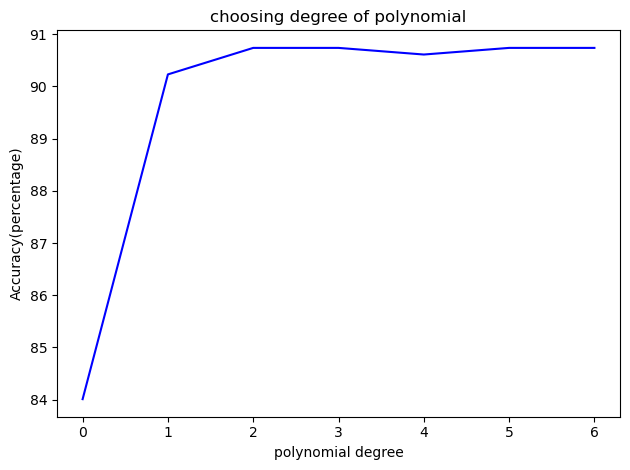

In [18]:
pca = PCA(n_components=4)
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

MAX_DEGREE = 7
n_list = [i for i in range(1,MAX_DEGREE + 1)] # degree list
classification_score = []
sensitivity_score = []
for n in n_list:
    # bayesain logistic regression
    poly = PolynomialFeatures(degree = n, interaction_only=False, include_bias=False)
    X_train_scaled_poly = poly.fit_transform(X_train_scaled)
    X_test_scaled_poly = poly.fit_transform(X_test_scaled)

    coeff = find_w_map(X_train_scaled_poly, y_train_scaled.flatten(), prior_variance=prior_variance)
    coeff = np.array(coeff).reshape(-1,1)
    y_pred = logistic(np.dot(X_test_scaled_poly,coeff))
    predictions = []
    for elem in y_pred:
        if(elem<0.5):
            predictions.append(0)
        else:
            predictions.append(1)
    correct = 0
    for i in range(len(predictions)):
        if(predictions[i]==list(y_test_scaled.flatten())[i]):
            correct = correct + 1

    score = correct/len(predictions)

    confusion = confusion_matrix(y_test_scaled,np.array(predictions).reshape(-1,1))
    TP = confusion[1,1] # true positive
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    sensitivity = TP / float(TP+FN)
    print(f"accuracy with degree = {n} is {score}")
    print(f"sensitivity with degree = {n} is {sensitivity}")
    classification_score.append(score*100)
    sensitivity_score.append(sensitivity*100)
    

plt.plot(classification_score,'b-')
# plt.plot(sensitivity_score,'r-')
plt.xlabel("polynomial degree")
# plt.ylabel(r"Accuracy(percentage), Sensitivity(percentage) ")
plt.ylabel(r"Accuracy(percentage)")

plt.title('choosing degree of polynomial')
# plt.legend(['accuracy','sensitivity'])
plt.tight_layout()
plt.savefig("plots/polynomial_degree_pca_bayesian_logistic.jpg",dpi=150)

plt.show()